In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import umap.umap_ as umap
import os

from abnativ.model.alignment.aho_consensus import cdr3_aho_indices

folder_figures = 'figures'


/Users/aubinramon/opt/anaconda3/envs/abnativ/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Clustering on ESM-1b
#  Database
csv = '/Users/aubinramon/PhD/computational/packages/nanomelt/datasets/NanoMelt_640_nanobody_apparent_melting_temperatures.csv'
input_data = pd.read_csv(csv)

fp_database = "data/database_640.pkl"
database = pd.read_pickle(fp_database)

database['tm'] = input_data['Measured apparent melting temperature (C)']
database['exp_method'] = input_data['Experimental method']
database.to_pickle(fp_database)

print(database.keys())
emb_type = 'esm1b'
# Using esm1b embedding for clustering
esm1b = database[emb_type].values
dist_matrix = np.vstack(esm1b)

clust_labels = database['clust_kmedoids_blosum']

print(set(clust_labels))


Index(['id', 'al_seq', 'seq', 'esm1b', 'esm2_t30', 'ablang', 'vhse',
       'antiberty', 'onehot', 'nanobuilder', 'nanobert', 'exp_method', 'tm',
       'clust_kmedoids_blosum', 'expmeth_clust_kmedoids_blosum',
       'clust_kmeans_esm1b', 'expmeth_clust_kmeans_esm1b'],
      dtype='object')
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [9]:
# Overlaying with background clusters

# 10k sequences esm1b embedding for distance matrix
fp_10k = "data/vhh_10k_realigned.pkl"
df_10k = pd.read_pickle(fp_10k)
esm1b_10k = df_10k[emb_type].values
dist_matrix_10k = np.vstack(esm1b_10k)

reducer = umap.UMAP(random_state=0, 
					metric='euclidean', 
					n_neighbors=20,
                    min_dist=0.1)

umappedP_10k = reducer.fit_transform(dist_matrix_10k)
umap_x_10k=umappedP_10k.T[0]
umap_y_10k=umappedP_10k.T[1]

umappedP = reducer.transform(dist_matrix)
umap_x=umappedP.T[0]
umap_y=umappedP.T[1]
df_to_plot = pd.DataFrame({'umap_x': umap_x, 'umap_y': umap_y, 'clust_labels': clust_labels})
df_to_plot = df_to_plot.sort_values(by='clust_labels')
df_to_plot['clust_labels'] = [str(x+1) for x in df_to_plot['clust_labels']]



/Users/aubinramon/opt/anaconda3/envs/abnativ/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


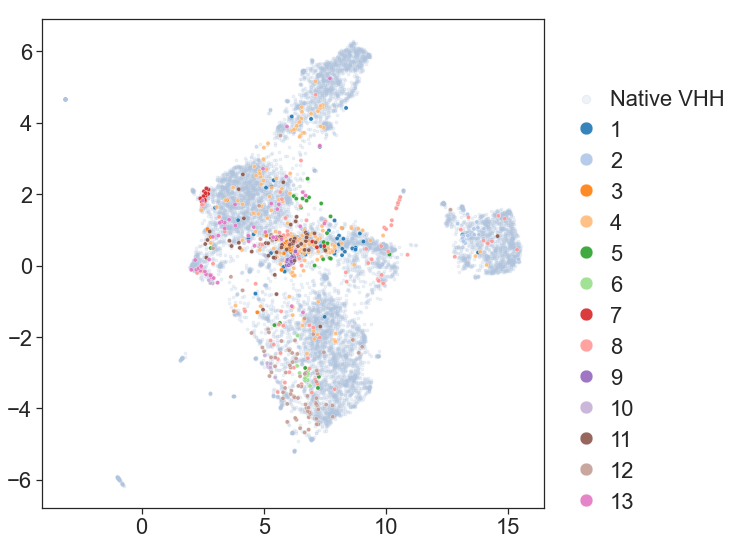

In [10]:
# Plotting
sns.set_theme(font_scale=1.2)
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'axes.spines.bottom': True,
                        'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'xtick.labeltop': False})
fig, ax = plt.subplots(figsize=(9, 9))
palette=sns.color_palette("tab20", 13)	
abnativ_plot = plt.scatter(umap_x_10k, umap_y_10k, s=8, c='lightsteelblue', alpha=0.2, label='Native V_{H}H')
scatter = sns.scatterplot(data=df_to_plot, x='umap_x', y='umap_y', hue='clust_labels', palette=palette, s=18, ax=ax,alpha=0.9)

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)

# Create custom legend handles
handles, labels = scatter.get_legend_handles_labels()
cluster_handles = handles[1:]  # exclude the first handle which is the title
cluster_labels = labels[1:]  # exclude the first label which is the title

# Add the AbNatiV handle and label
custom_handles = handles
custom_labels = ['Native VHH'] + ['' + i for i in cluster_labels]

# Adjust legend
l=plt.legend(title='Sequence\nClusters\n(K-Means)\nlol', handles=custom_handles, labels=custom_labels, loc='center left',
           bbox_to_anchor=(1, 0.5), markerscale=3, ncol=1, fontsize=22, frameon=False, handletextpad=0.1, columnspacing=0)
l.get_title().set_color("white")

plt.tick_params(bottom=True, left=True, labelsize=22)
sns.despine(right=False, top=False)
plt.savefig(os.path.join(folder_figures, 'figure3c.png'), dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()


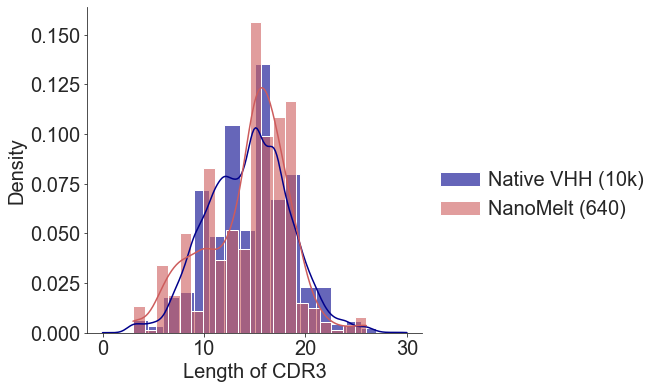

In [5]:
# CDR3-length 
cdr3_length = [len(seq[cdr3_aho_indices[0]:cdr3_aho_indices[-1]].replace('-','')) for seq in df_10k['al_seq']]
df_10k['cdr3_length'] = cdr3_length

cdr3_length = [len(seq[cdr3_aho_indices[0]:cdr3_aho_indices[-1]].replace('-','')) for seq in database['al_seq']]
database['cdr3_length'] = cdr3_length


sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False,
                    'xtick.bottom': True, 'ytick.left': True})


plt.figure(figsize=(6,6))

sns.histplot(df_10k, x="cdr3_length", bins=20, kde=True, color='darkblue', stat='density',label='Native VHH (10k)',alpha=0.6)
sns.histplot(database, x="cdr3_length", bins=20, kde=True, color='indianred', stat='density',label='NanoMelt (640)',alpha=0.6)


plt.xlabel(f"Length of CDR3", fontsize=20)
plt.ylabel(f"Density", fontsize=20)

l=plt.legend(title='Sequence\nClusters\n(K-Means)\nlol',  loc='center left',
           bbox_to_anchor=(1, 0.5), markerscale=3, ncol=1, fontsize=20, frameon=False, handletextpad=0.4, columnspacing=0)
l.get_title().set_color("white")

#plt.title(f"Measured Melting Temperature \naverage Tm = {mean_tm}", fontsize=18, y=1.02)
plt.tick_params(bottom=True, left=True, labelsize=20)
#plt.ylim(0,95)
plt.savefig(os.path.join(folder_figures, 'figureS5a.png'), dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()



In [6]:
import anarci
from anarci.germlines import all_germlines

def calculate_shm(sequences, chain_type="H"):
    # Run ANARCI
    results = anarci.run_anarci(sequences, scheme="aho", allow=chain_type, allowed_species=['alpaca'], assign_germline=True)

    
    germ_ids, germ_vs = list(), list()

    for i in range(len(sequences)):
        germlines = results[2][i][0]['germlines']

        v_germline_seq = all_germlines['V']['H'][germlines['v_gene'][0][0]][germlines['v_gene'][0][1]]                                                               
        germline_identity = germlines['v_gene'][1]
        v_germline = germlines['v_gene'][0][1]

        germ_ids.append(germline_identity)
        germ_vs.append(v_germline)

    return germ_ids, germ_vs


list_seqs = [(id, seq) for id, seq in zip(database['id'], database['seq'])]
germ_ids_database, germ_vs_database = calculate_shm(list_seqs)
database['germline_identity'] = germ_ids_database
database['v-gene'] = germ_vs_database

list_seqs = [(id, seq) for id, seq in zip(df_10k['id'], df_10k['seq'])]
germ_ids_10k, germ_vs_10k = calculate_shm(list_seqs)
df_10k['germline_identity'] = germ_ids_10k
df_10k['v-gene'] = germ_vs_10k



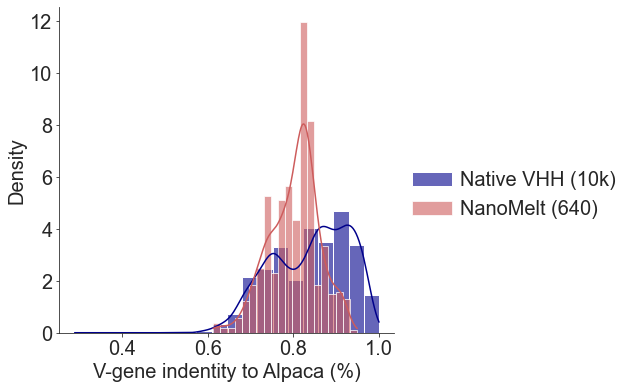

In [7]:
## Plot germline identities
sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False,
                    'xtick.bottom': True, 'ytick.left': True})

plt.figure(figsize=(6,6))

sns.histplot(df_10k, x="germline_identity", bins=20, kde=True, color='darkblue', stat='density',label='Native VHH (10k)',alpha=0.6)
sns.histplot(database, x="germline_identity", bins=20, kde=True, color='indianred', stat='density',label='NanoMelt (640)',alpha=0.6)


plt.xlabel(f"V-gene indentity to Alpaca (%)", fontsize=20)
plt.ylabel(f"Density", fontsize=20)

l=plt.legend(title='Sequence\nClusters\n(K-Means)\nlol',  loc='center left',
           bbox_to_anchor=(1, 0.5), markerscale=3, ncol=1, fontsize=20, frameon=False, handletextpad=0.4, columnspacing=0)
l.get_title().set_color("white")

#plt.title(f"Measured Melting Temperature \naverage Tm = {mean_tm}", fontsize=18, y=1.02)
plt.tick_params(bottom=True, left=True, labelsize=20)
#plt.ylim(0,95)
plt.savefig(os.path.join(folder_figures, 'figureS5b.png'), dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()


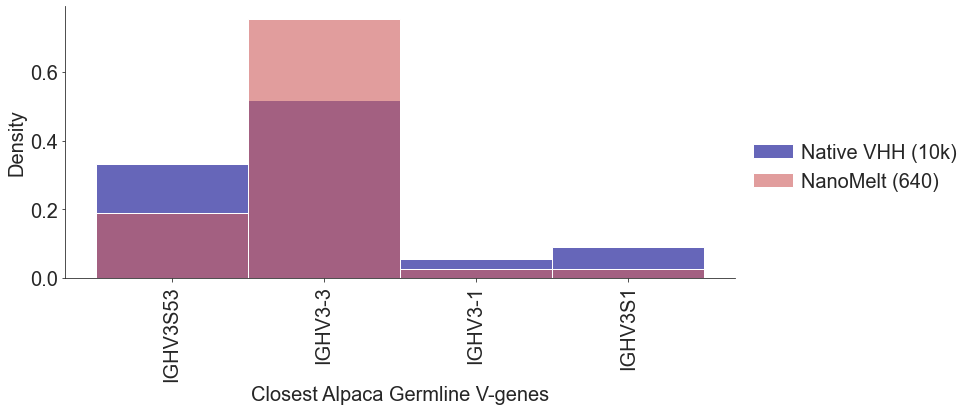

In [8]:
database['v-gene'] = [gene.split('*')[0] for gene in database['v-gene']]
df_10k['v-gene'] = [gene.split('*')[0] for gene in df_10k['v-gene']]

# Plot v-genes
sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False,
                    'xtick.bottom': True, 'ytick.left': True})

plt.figure(figsize=(12,5))

sns.histplot(df_10k, x="v-gene", bins=20,  color='darkblue', stat='density',label='Native VHH (10k)',alpha=0.6)
sns.histplot(database, x="v-gene", bins=20, color='indianred', stat='density',label='NanoMelt (640)',alpha=0.6)


plt.xlabel(f"Closest Alpaca Germline V-genes", fontsize=20)
plt.ylabel(f"Density", fontsize=20)

l=plt.legend(title='Sequence\nClusters\n(K-Means)\nlol',  loc='center left',
           bbox_to_anchor=(1, 0.5), markerscale=3, ncol=1, fontsize=20, frameon=False, handletextpad=0.4, columnspacing=0)
l.get_title().set_color("white")

#plt.title(f"Measured Melting Temperature \naverage Tm = {mean_tm}", fontsize=18, y=1.02)
plt.xticks(rotation=90)
plt.tick_params(bottom=True, left=True, labelsize=20)

#plt.ylim(0,95)
plt.savefig(os.path.join(folder_figures, 'figureS5c.png'), dpi=800, bbox_inches='tight', transparent=True)
plt.show()
plt.close()